# 2021 NSW Census and Juvenile Victims Features Correlation by LGA
We want to find the correlation between the 2021 features of Juvenile Victims and the Census, by LGA. The steps are:
<ol>
<li>Retrieve Features from 2021 NSW Census and Juvenile Victims by LGA</li>
<li>Calculate correlations to select the best features</li>
<li>Rank the best features</li>
</ol>


## 1. Retrieve Features from NSW Census and Juvenile Victims by LGA

Load libraries

In [1]:
import pandas as pd
import numpy as np

#ignore warnings
import warnings
warnings.filterwarnings('ignore')

Import connection functions (pipelines)

In [2]:
# Import the os module
import os

# Print the current working directory
print("Current working directory: {0}".format(os.getcwd()))

# Change the current working directory
os.chdir('G:/My drive/NSW Offences/Scripts/')

# Print the current working directory
print("Current working directory: {0}".format(os.getcwd()))

import pipeline

Current working directory: C:\Users\cladi\Downloads
Current working directory: G:\My drive\NSW Offences\Scripts


Read DB connection credential

In [3]:
credentials=pd.read_excel("G:/My drive/NSW Offences/Scripts/connection.xlsx")

Query to get the Juvenile Victims data from our Crime DB

In [4]:
query_string=""" SELECT * FROM prod."2021_census.gcp_all_juvenile_victims.lga"  """
original_data = pipeline.do_query(query_string, credentials.user.iloc[0],credentials.password.iloc[0], credentials.host.iloc[0],credentials.port.iloc[0], credentials.database.iloc[0])
original_data=original_data.set_index('index')
original_data=original_data.T
model_data=original_data.copy()
model_data
model_data=model_data.drop(['lga_code_2021'], axis=1)
model_data.head()
model_data.columns

PostgreSQL connection is closed


Index(['g53b.f_accomfoods_cert', 'g53b.f_accomfoods_id_ns',
       'g53b.f_accomfoods_tot', 'g53b.f_transpostwhse_pd',
       'g53b.f_transpostwhse_gd_gc', 'g53b.f_transpostwhse_bd',
       'g53b.f_transpostwhse_add_d', 'g53b.f_transpostwhse_cert',
       'g53b.f_transpostwhse_id_ns', 'g53b.f_transpostwhse_tot',
       ...
       'domestic_violence_related_assault.rate',
       'nondomestic_violence_related_assault.rate', 'sexual_offences.rate',
       'abduction_and_kidnapping.rate', 'robbery.rate',
       'blackmail_and_extortion.rate',
       'intimidation_stalking_and_harassment.rate',
       'other_offences_against_the_person.rate', 'arson.rate',
       'breach_apprehended_violence_order.rate'],
      dtype='object', name='index', length=17006)

Select Juvenile Victims rates from the data

In [5]:
#split df
len(model_data.columns)
bocsardata=model_data.iloc[:,-10:].copy() #removed 'homicide rate' as is mostly 0
censusdata=model_data.iloc[:,:len(model_data.columns)-22].copy() 

## 2. Calculate correlations and select the best features

In [6]:
selected_features_all=pd.DataFrame()

#iterate on the different features
for column in bocsardata:
    target_feature= column[:-5]
    model_data=pd.concat([censusdata,bocsardata[[target_feature+'.rate']]], axis=1)
    
    #Create categories for every Juvenile Victims rates (buckets / stratification)
    #feature engineering

    bin_labels = ['Low', 'High']
    model_data[target_feature+'.quantiles'] = pd.qcut(model_data[target_feature+".rate"],
                              q=[0, .5, 1],
                              labels=bin_labels)
    model_data=model_data.drop(columns=[target_feature+".rate"])
    
    #Select last column (Juvenile Victims feature) 
    new_cols = [col for col in model_data.columns if col != (target_feature+'.quantiles')] + [(target_feature+'.quantiles')]
    model_data = model_data[new_cols]
    
    #Tranform to binary (dummy var)
    from sklearn.preprocessing import LabelEncoder
    lbl=LabelEncoder()
    dummies = lbl.fit_transform(model_data[target_feature+".quantiles"])
    model_data[target_feature+".quantiles.bin"]=dummies
    model_data.iloc[:, -2:]
    model_data=model_data.drop(columns=[target_feature+'.quantiles'])

    ## 2. Calculate correlations and select the best features
    
    target_feature=target_feature+'.quantiles.bin'
    #Do the correlation
    corr_data=model_data.copy()
    corr_table=corr_data.corr()
    corr_table=pd.DataFrame(corr_table)
    # Select upper triangle of correlation matrix
    upper = corr_table.where(np.triu(np.ones(corr_table.shape), k=1).astype(np.bool))
    #select the last row, check if any value is >0.5, keep that column, else drop 
    last_col = corr_table.iloc[:,-1]      
    last_col=pd.DataFrame(last_col)
    last_col.drop(last_col.tail(1).index,inplace=True) # drop last n rows
    selected_features=last_col.loc[last_col[target_feature].abs() >= 0.5]
    selected_features
    selected_features_all=pd.merge(selected_features_all, selected_features, how = 'outer',left_index=True, right_index=True)
    print('correlation for '+column+ ' complete')
selected_features_all.head()

correlation for domestic_violence_related_assault.rate complete
correlation for nondomestic_violence_related_assault.rate complete
correlation for sexual_offences.rate complete
correlation for abduction_and_kidnapping.rate complete
correlation for robbery.rate complete
correlation for blackmail_and_extortion.rate complete
correlation for intimidation_stalking_and_harassment.rate complete
correlation for other_offences_against_the_person.rate complete
correlation for arson.rate complete
correlation for breach_apprehended_violence_order.rate complete


,domestic_violence_related_assault.quantiles.bin,nondomestic_violence_related_assault.quantiles.bin,sexual_offences.quantiles.bin,abduction_and_kidnapping.quantiles.bin,robbery.quantiles.bin,blackmail_and_extortion.quantiles.bin,intimidation_stalking_and_harassment.quantiles.bin,other_offences_against_the_person.quantiles.bin,arson.quantiles.bin,breach_apprehended_violence_order.quantiles.bin
index,,,,,,,,,,
g01.age_0_4_yr_f,NaN,NaN,NaN,0.599235,NaN,0.599235,NaN,0.591688,0.599235,NaN
g01.age_0_4_yr_m,NaN,NaN,NaN,0.597468,NaN,0.597468,NaN,0.590676,0.597468,NaN
g01.age_0_4_yr_p,NaN,NaN,NaN,0.598454,NaN,0.598454,NaN,0.591293,0.598454,NaN
g01.age_15_19_yr_f,NaN,NaN,NaN,0.621321,0.527823,0.621321,NaN,0.611257,0.621321,NaN
g01.age_15_19_yr_m,NaN,NaN,NaN,0.616755,0.524018,0.616755,NaN,0.608023,0.616755,NaN


## 3. Rank the best features

Sum the correlation per feature and rank the percentage (descending)

In [7]:
importance=pd.DataFrame(index=selected_features_all.index)
importance["sum"]=selected_features_all.abs().sum(axis=1)
importance["percentage"]= 100*importance["sum"]/ (len(selected_features_all.columns))
importance["rank"]=importance["percentage"].rank(ascending=False)
importance=importance.sort_values('rank')

#top 10
importance.head(500)

,sum,percentage,rank
index,,,
g02.median_rent_weekly,5.382620,53.826198,1.0
g02.median_mortgage_repay_monthly,4.970615,49.706145,2.0
g59a.i_4000more_emp_wpt,4.103237,41.032369,3.0
g50a.m_health_65_74,3.985158,39.851577,4.0
g50a.m_health_55_64,3.953453,39.534535,5.0
...,...,...,...
g24a.m_45_54y_dudw_5_14_h,3.683785,36.837848,496.0
g28.p_50_54_yrs_total,3.683745,36.837449,498.0
g07.a_50_54_y_tot_f,3.683745,36.837449,498.0


Distribution of the sum of the correlation for all the features 

<AxesSubplot:ylabel='Frequency'>

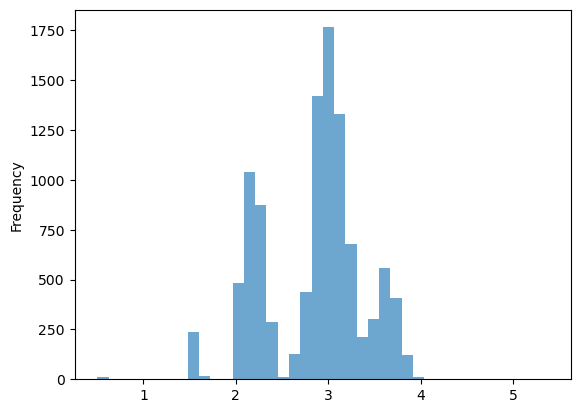

In [8]:
importance["sum"].plot.hist(alpha = 0.65, bins = 40)

<AxesSubplot:>

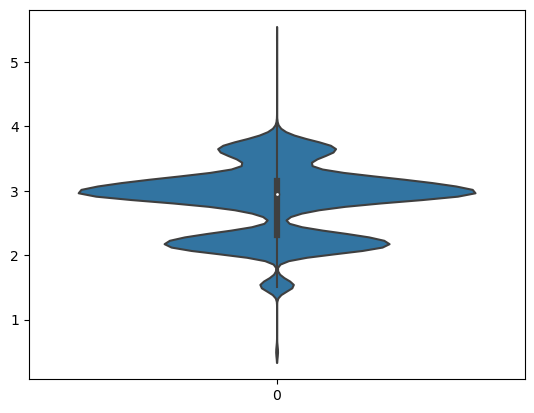

In [9]:
import seaborn as sns
sns.violinplot(importance["sum"])

<AxesSubplot:ylabel='sum'>

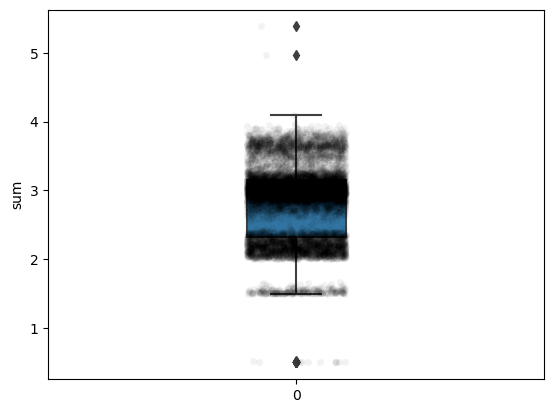

In [10]:
sns.boxplot(importance["sum"], width=0.2)
sns.stripplot(importance["sum"], jitter=True, alpha=0.05, color='black')

### Explore the Top correlated features with the crime data

Scatterplot Matrix of Top 10 correlated features

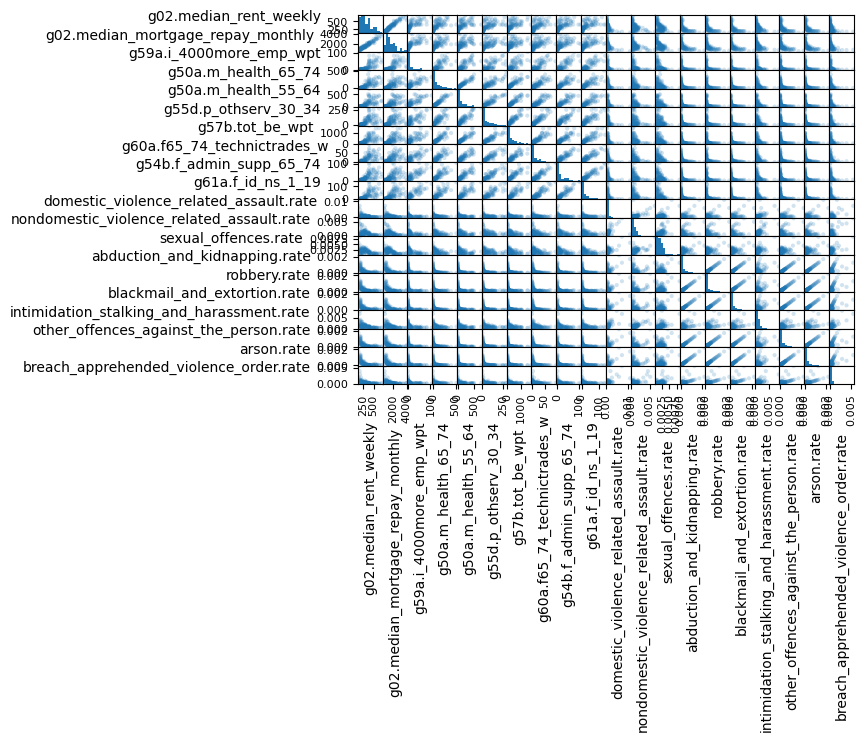

In [11]:
scatterdata=pd.concat([original_data[importance.head(10).index],bocsardata], axis=1)

axes = pd.plotting.scatter_matrix(scatterdata, alpha=0.2)
for ax in axes.flatten():
    ax.xaxis.label.set_rotation(90)
    ax.yaxis.label.set_rotation(0)
    ax.yaxis.label.set_ha('right')


# Group the Top 10 features by their Profile Tables (Packs) from the Census. Plot the count and percentage.

PostgreSQL connection is closed


<AxesSubplot:ylabel='Table Name'>

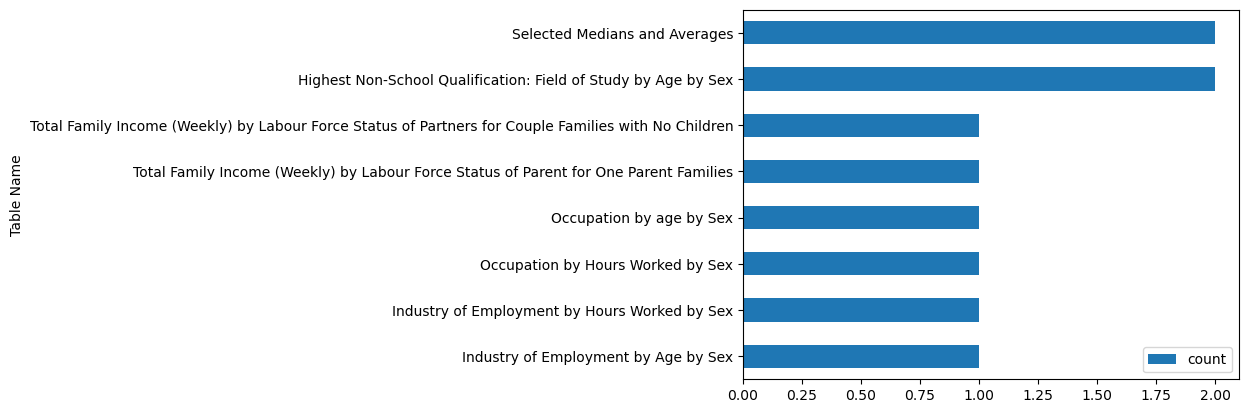

In [24]:
#select the top 10
top_features_selected=importance.head(10)

#features description from census
query_string=""" SELECT "Short", "LongName", "Table Name" FROM prod."2021_census.gcp_nsw.dict_transformed"  """
features_desc = pipeline.do_query(query_string, credentials.user.iloc[0],credentials.password.iloc[0], credentials.host.iloc[0],credentials.port.iloc[0], credentials.database.iloc[0])
features_desc=features_desc.set_index('Short')

#merge and show top 10
result = pd.merge(top_features_selected, features_desc,left_index=True, right_index=True)

#count
bars_data=result.groupby(['Table Name']).size()
bars_data=pd.DataFrame(bars_data, columns=['count'])
bars_data=bars_data.sort_values(['count'],ascending=[True])
bars_data.plot.barh()

<AxesSubplot:ylabel='Table Name'>

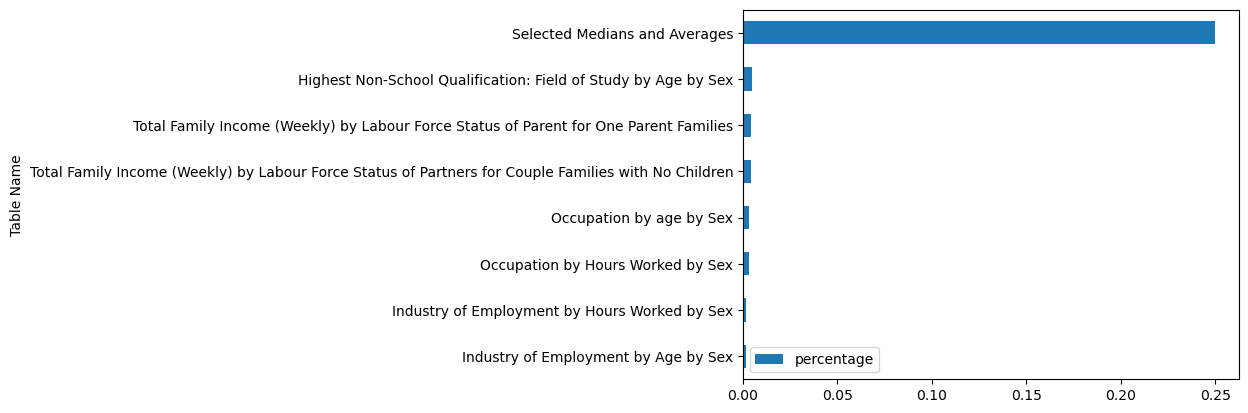

In [28]:
#percentage
features_all=features_desc.copy()
total_f=features_all.groupby(['Table Name']).size()
total_f=pd.DataFrame(total_f, columns=['count'])
perc_total= pd.merge(total_f, bars_data, left_index=True, right_index=True)
perc_total['percentage']=perc_total['count_y']/perc_total['count_x']
bars_data_perc=pd.DataFrame(perc_total['percentage'], columns=['percentage'])
bars_data_perc=bars_data_perc.sort_values(['percentage'],ascending=[True])
bars_data_perc.plot.barh()

The count plot helps to understand the number of top 10 features by "Profile Table", and the percentage helps to standardize the count since there are "Profile Tables" with more features than others.

Analysing both tables, we see "Selected Medians and Averages" is the "Profile Table" with the highest number of top 10 features. The second one is "Highest Non-School Qualification: Field of Study by Age by Sex", followed by "Total Family Income (Weekly) by Labour Force Status of Parent for One Parent Families".